# Implementation of LSTM
## Variables to Consider
<ul>
    <li>Hidden Parameters (more seems better until 10)</li>
    <li>Hidden Layers (more than 1 seems useless, makes sense because input is few dimensions)</li>
    <li>Learning Rate (smaller learning rate requires more epoches to achieve similar results)</li>
    <li>Mini-Batch Size (seems to have slight improvement)</li>
    <li>Number Epochs</li>
    <li>Sequence Length (4)</li>
    <li>Length of Prediction (1)</li>
</ul>

In [1]:
#!pip uninstall statsmodels
#!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from os import listdir
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")

Using CUDA


In [3]:
class Parameters():
    def __init__(self, num_layers = 1, hidden_size = 10, batch_size = 100, seq_len = 6, pred_len = 3, num_epochs = 20, learning_rate = 0.01, dropout = 1):
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.dropout = dropout
    
    def __str__(self):
        return "{}-{}-{}-{}-{}-{}-{}-{}".format(self.num_layers, self.hidden_size, self.batch_size, self.seq_len, self.pred_len, self.num_epochs, self.learning_rate, self.dropout)


# Data Loading

In [25]:
def readData(file='samples/WY.csv', freq=20, plot=False):
    data = pd.read_csv(file, delimiter=',', index_col=0, parse_dates=True)
    if plot:
        plt.figure(figsize=(20, 4))
        plt.plot(data)
    
    data = data.resample(str(freq) + 'T').mean() # means the bin of size freq
    raw_values = np.asarray(data['CpuUtilizationAverage']).reshape(data.shape[0], 1)
    return raw_values

training_set = readData()

In [6]:
from torch.utils.data import TensorDataset, DataLoader

# Struct used to store intermediate data variables
class Data:
    pass

# Generates data using the sliding window method with variable sequene and prediction length
def large_sliding_windows(data, seq_length, pred_length=2):
    x = []
    y = []

    for i in range(len(data)-seq_length-pred_length+1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+seq_length+pred_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Generates data using the sliding window method with variable sequence length
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [29]:
# Generates the training/test set and stores in d using provided training set and parameters
def generateData(training_set, d, params):
    d.sc = MinMaxScaler()
    training_data = d.sc.fit_transform(training_set) # normalizes the data

    x, y = large_sliding_windows(training_data, params.seq_len, params.pred_len)

    d.max_size = int(params.batch_size*(len(y)//params.batch_size))
    d.train_size = int(params.batch_size*(d.max_size*(0.8)//params.batch_size))
    d.test_size = d.max_size-d.train_size

    d.dataX = Variable(torch.Tensor(np.array(x[0:d.max_size])))
    d.dataY = Variable(torch.Tensor(np.array(y[0:d.max_size])))

    d.trainX = Variable(torch.Tensor(np.array(x[0:d.train_size]))).to(device)
    d.trainY = Variable(torch.Tensor(np.array(y[0:d.train_size]))).to(device)
    train_data = TensorDataset(d.trainX, d.trainY)
    d.train_loader = DataLoader(train_data, shuffle=False, batch_size=params.batch_size)

    d.testX = Variable(torch.Tensor(np.array(x[d.train_size:d.max_size]))).to(device)
    d.testY = Variable(torch.Tensor(np.array(y[d.train_size:d.max_size]))).to(device)
    test_data = TensorDataset(d.dataX, d.dataY)
    d.test_loader = DataLoader(test_data, shuffle=False, batch_size=params.batch_size)
    return d

data = Data()
params = Parameters()
generateData(training_set, data, params)

# Generate Naive Examples

In [32]:
def generateNaive(d, params):
    # always predicts the last training example
    global_naive = np.full(d.testY.shape, d.trainX[-1][-1].item())
    
    # always predicts the average of seen training examples
    global_mean = np.full(d.testY.shape, d.trainY.mean().item())
    
    # predicts the last seen value of the sliding window
    local_naive = np.ones(d.testY.shape)
    for row in local_naive:
        for i in range(params.pred_len):
            row[i] = d.testX[i][-1].item()
    local_mean = np.ones(d.testY.shape)
    
    # predicts the average of the values seen in the last sliding window
    for row, test_row in zip(local_mean, d.testX):
        for i in range(params.pred_len):
            row[i] = np.mean(test_row.cpu().numpy())

    denormalize=True
    naives = [global_naive, global_mean, local_naive, local_mean]
    
    for naive in naives:
        naive = naive.reshape(naive.shape[:-2]+ (-1,))
        if denormalize: naive = d.sc.inverse_transform(naive)

    return naives

naives  = generateNaive(data, params)

# LSTM Model

In [13]:
class LSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_dim, n_layers, drop_prob=0):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        
        # manually takes the last hidden layer and passes through linear transform
        h_out = hidden[0][-1].view(-1, self.hidden_dim)
        out = self.fc(h_out)
        return out, hidden
    
    # initializes weights and biases to 0
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

# Training

In [42]:
class Model:
    def __init__(self, lstm, h, criterion):
        self.lstm, self.h, self.criterion = lstm, h, criterion

def train(d, params, print_every=10):
    input_size = 1 # dimensions not length of input

    lstm = LSTM(params.pred_len, input_size, params.hidden_size, params.num_layers, params.dropout)
    lstm.to(device)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=params.learning_rate)

    h = lstm.init_hidden(params.batch_size)

    # Train the model
    for epoch in range(params.num_epochs):
        for x, y in d.train_loader:
            h = tuple([e.data for e in h])
            outputs, h = lstm(x, h)
            optimizer.zero_grad() # remove stored gradient

            # obtain the loss function
            y = y.reshape(y.shape[:-2] + (-1,))
            loss = criterion(outputs, y)

            loss.backward()

            optimizer.step()
        if print_every > 0 and epoch % print_every == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            
    model = Model(lstm, h, criterion)
    return model
            
model = train(data, params)

Epoch: 0, loss: 0.57721
Epoch: 10, loss: 0.00352
Epoch: 20, loss: 0.00335


Testing

<Figure size 432x288 with 0 Axes>

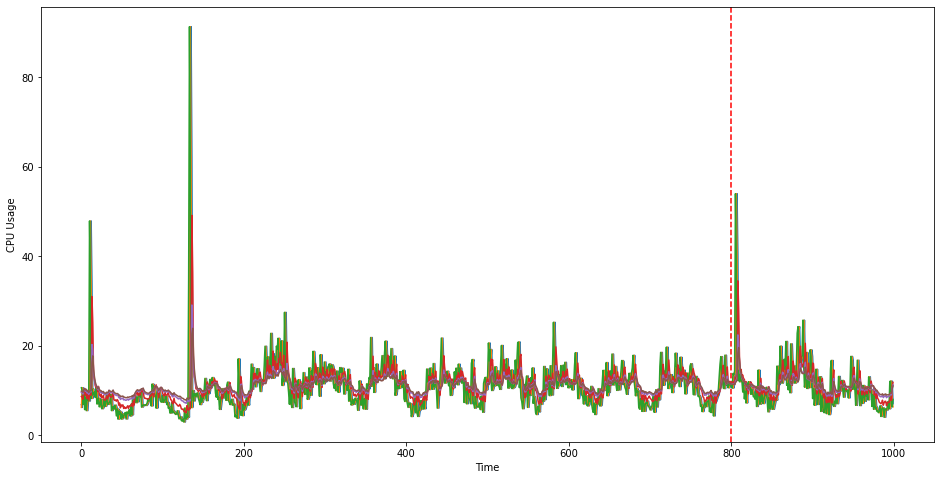

In [20]:
def test(model, d, params, show_plot=True):
    model.lstm.eval()
    test_predict = np.zeros((data.max_size, params.pred_len))
    test_losses = []

    for i, (x, y) in enumerate(d.test_loader):
        model.h = tuple([each.data for each in model.h])
        x, y = x.to(device), y.to(device)
        output, model.h = model.lstm(x, model.h)
        y = y.reshape(y.shape[:-2] + (-1,))
        test_loss = model.criterion(output.squeeze(), y)
        test_losses.append(test_loss.item())
        for j in range(params.batch_size):
            for k in range(params.pred_len):
                test_predict[j+i*100][k] = output[j][k].item()

    data_predict = test_predict
    dataY_plot = d.dataY.data.numpy()

    dataY_plot = dataY_plot.reshape(dataY_plot.shape[:-2] + (-1,))

    d.data_predict_transform = d.sc.inverse_transform(data_predict)
    d.dataY_plot_transform = d.sc.inverse_transform(dataY_plot)
    
    if show_plot: plotResults(d)
    
    return (d.data_predict_transform[d.train_size:], d.dataY_plot_transform[d.train_size:])

def plotResults(d, type=1):
    if type == 0:
        plt.clf()
        plt.figure(figsize=(16, 8))
        plt.axvline(x=d.train_size, c='r', linestyle='--') # data shift from train to test
        plt.plot(d.dataY_plot_transform)
        plt.plot(d.data_predict_transform)
        plt.ylabel("CPU Usage")
        plt.xlabel("Time")
        plt.show()
    else if type == 1:
        plt.clf()
        xs = [i for i in range(0, 600, 1)]
        plt.plot(d.dataY_plot_transform[400:800], c='blue')
        xpts = [i for i in range(d.train_size-400, d.dataY_plot_transform.shape[0]-400, 1)]
        plt.plot(xs[400:], d.data_predict_transform[d.train_size:], c='green')
        plt.plot(xs[400:], d.dataY_plot_transform[800:], c='blue', alpha=0.3)
        plt.title('CPU Prediction with LSTM')
        plt.xlabel('Time')
        plt.ylabel('CPU Usage')
        plt.show()


preds, labels = test(model, data, params)


Image may be unclear for models predicting more than a single point at a time

# Accuracy Calculations

In [23]:
# Mean Average Percent Error
def mape(preds, labels, prnt=False):
    preds = preds.flatten()
    labels = labels.flatten()
    err = 0
    for i, (pred, label) in enumerate(zip(preds, labels)):
        denum = np.absolute(label) if np.round(label) !=0 else 50 # accounts for divide by 0 error
        err += (np.absolute(pred-label) / denum)
            
    err /= preds.shape[0]
    if prnt: print("MAPE - {}".format(err))
    return err
    
# Brier Score or Mean Squared Error
def mse(preds, labels, prnt=False):
    preds = preds.flatten()
    labels = labels.flatten()
    err = np.sum(np.power(preds-labels, 2)) / preds.shape[0]
    if prnt: print("MSE - {}".format(err))
    return err
    
# Mean Average Error
def mae(preds, labels, prnt=False):
    preds = preds.flatten()
    labels = labels.flatten()
    err = (np.sum(np.absolute(preds-labels))) / preds.shape[0]
    if prnt: print("MAE - {}".format(err))
    return err
    
# Root Mean Squared Error
def rmse(preds, labels, prnt=False):
    err = np.power(mse(preds, labels), 0.5)
    if prnt: print("RMSE - {}".format(err))
    return err

# Symmetric Mean Absolute Percentage Error
# some issues in bias, but commonly used
def smape(preds, labels, prnt=False):
    preds = preds.flatten()
    labels = labels.flatten()
    err = 0
    for (pred, label) in zip(preds, labels):
        denum = np.absolute(pred)+np.absolute(label) if np.absolute(pred)+np.absolute(label) !=0 else np.max(labels) #check!!
        err += (np.absolute(pred-label) / denum)
    err /= preds.shape[0]
    if prnt: print("SMAPE - {}".format(err))
    return err

# errors = [mape, mse, rmse, smape]
errors = [mae, rmse, mape]

def print_errors(preds, labels, prnt=False):
    err_results = []
    for error in errors:
        err_results.append(error(preds, labels, prnt))
    return err_results
    
print("----- LSTM Results -----")
print_errors(preds, labels, prnt=True)
print("\n----- Naive Results -----")
for naive in naives:
    print_errors(naive, labels, prnt=True)

----- LSTM Results -----
MAE - 2.955980352728369
RMSE - 4.7775365374928045
MAPE - 0.2978781019613628

----- Naive Results -----
MAE - 10.70703690757354
RMSE - 12.006722108282233
MAPE - 0.9905650995408662
MAE - 10.706198307474454
RMSE - 12.00597428967513
MAPE - 0.9904736793530264
MAE - 10.697892005344231
RMSE - 11.998563934472426
MAPE - 0.9895688326359323
MAE - 10.704093098569041
RMSE - 11.995424731051372
MAPE - 0.9912754944039439


# Testing Script
Parameters(num_layers, hidden_size, batch_size, seq_len, pred_len, epochs, learning_rate, dropout)

In [46]:
ps = []
# Standardized parameters
batch_size = 100
learning_rate = 0.01
epochs = 30

# Short term parameters
seq_len = 6
pred_len = 3

# Long term parameters
#seq_len = 432
#pred_len = 216

# Varies hyper parameters being measured
for num_layers in range(1, 5, 1):
    for dropout in np.linspace(0,1,11):
        for hidden_size in [2, 5, 10, 20]:
            ps.append(Parameters(num_layers, hidden_size, batch_size, seq_len, pred_len, epochs, learning_rate, dropout))


for params in tqdm(ps):
    columns = ['MAE', 'RMSE', 'MAPE', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_MAPE', 'NAIVE_MAE', 'NAIVE_RMSE', 'NAIVE_MAPE']
    df = pd.DataFrame(columns = columns, dtype=np.float64)
    for i, state in enumerate(listdir("samples/")):
        # Load Data
        data = Data()
        data.name = state.replace(".csv", "")
        training_set = readData("samples/"+state, freq=20)
        generateData(training_set, data, params)
        
        # Generate Naives
        naives  = generateNaive(data, params)
        
        # Train Model
        model = train(data, params, print_every=-1)
        
        # Test Model
        preds, labels = test(model, data, params, show_plot=False)
        
        # Store Results
        err_results = print_errors(preds, labels)
        for naive in naives[2:]: # stores only local naive models
            err_results.extend(print_errors(naive, labels))
        row_df = pd.DataFrame([err_results], index = [state.replace(".csv", "")], columns = columns, dtype=np.float64)
        df = pd.concat([row_df, df])
        #print("{} - MAE ({}) - MAPE ({})".format(state.replace(".csv", ""), round(err_results[0], 2), round(err_results[2], 2)))
    
    df.to_csv("lstm-out/{}.csv".format(params))


  2%|▏         | 4/176 [02:17<1:38:45, 34.45s/it]/home/rayan/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/rayan/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/rayan/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/rayan/.local/li

KeyboardInterrupt: 